In [1]:
cd ../../

/home/michael/Dropbox/PhD/Python/unified_model


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# Mechanical system imports
from unified_model.mechanical_system.mechanical_system import MechanicalSystem
from unified_model.mechanical_system.model import ode_decoupled
from unified_model.mechanical_system.damper.damper import Damper
from unified_model.mechanical_system.input_excitation.accelerometer import AccelerometerInput
from unified_model.mechanical_system.input_excitation.footstep import Footstep
from unified_model.mechanical_system.spring.magnetic_spring import MagneticSpring
from unified_model.mechanical_system.magnet_assembly.magnet_assembly import MagnetAssembly
from unified_model.mechanical_system.evaluator import LabeledProcessor, MechanicalSystemEvaluator

# Electrical system imports
from unified_model.electrical_system.flux.utils import FluxDatabase
from unified_model.electrical_system.flux.model import flux_interpolate
from unified_model.electrical_system.electrical_system import OpenCircuitSystem

In [4]:
spring = MagneticSpring(fea_data_file = 'unified_model/mechanical_system/spring/data/10x10alt.csv', model='savgol_smoothing', model_type='interp')
magnet_assembly = MagnetAssembly(n_magnet=1,
                                h_magnet=10,
                                h_spacer=0,
                                dia_magnet=10,
                                dia_spacer=10)
damper = Damper(model='constant', model_kwargs={'damping_coefficient' : 0.028})
accelerometer = AccelerometerInput('unified_model/mechanical_system/input_excitation/data/2018-10-04/log_02.csv',
                                  accel_column='z_G',
                                  time_column='time(ms)',
                                  time_unit='ms')

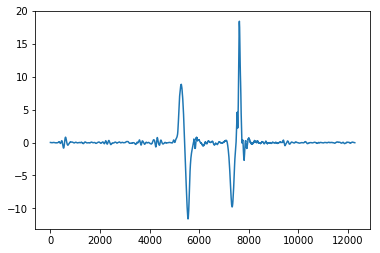

In [5]:
plt.plot(accelerometer.acceleration_df['z_G'], label='original')

In [6]:
system = MechanicalSystem()
system.set_spring(spring)
system.set_damper(damper)
system.set_input(accelerometer)
system.set_magnet_assembly(magnet_assembly)
system.set_model('ode_decoupled', initial_conditions=[0, 0, 0.04, 0])

In [7]:
t = np.arange(1.5, 8.5, 0.005)

In [8]:
system.solve(t)

In [9]:
system.get_output().head()

,time,tube_displacement,tube_velocity,assembly_displacement,assembly_velocity,assembly_relative_displacement,assembly_relative_velocity
0,1.500,0.000000e+00,0.000000,0.040000,0.000000,0.040000,0.000000
1,1.505,-1.246083e-12,-0.000638,0.040013,0.005049,0.040013,0.005687
2,1.510,-1.246083e-12,-0.001644,0.040050,0.009906,0.040050,0.011550
3,1.515,-1.246083e-12,-0.002959,0.040111,0.014504,0.040111,0.017463
4,1.520,-1.246083e-12,-0.004427,0.040195,0.018783,0.040195,0.023210


In [10]:
df_pred = system.get_output().copy()

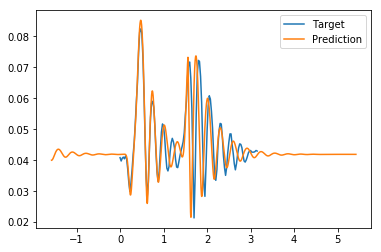

In [11]:
lp = LabeledProcessor(L=125, mf=14, mm=10, seconds_per_frame=0.025)
y_actual, timesteps = lp.fit_transform(pd.read_csv('unified_model/mechanical_system/input_excitation/data/2018-10-04/test-02_transcoded_subsampled_labels_2018-10-12-14:11:27.csv'))
y_predicted = df_pred['assembly_relative_displacement'].values
time_predicted = df_pred['time'].values - df_pred['time'].min()

e = Evaluator(y_target=y_actual, time_target=timesteps)
e.fit(y_predicted=y_predicted, time_predicted=time_predicted)
e.poof()

# Electrical model

In [12]:
# flux database
fdb = FluxDatabase('../Research/fea-flux-curves-numr[1-20-600]-numz[1-20-600]-wdiam[0.127]-2018-03-24[10.45.22].csv', fixed_velocity=0.35)

In [122]:
phi = fdb.query(winding_num_z='41', winding_num_r='41')
z = fdb.z
ocs = OpenCircuitSystem(z_index=z, phi_arr=phi, flux_model='flux_interpolate', coil_center=0.06, mf=magnet_assembly.get_height())

In [123]:
def return_emf(ocs, time_arr, z_arr):
    emf = []
    for t, z in zip(time_arr, z_arr):
        emf.append(ocs.get_emf(t, z))
        
    return emf

In [126]:
emf_predicted_actual = return_emf(ocs, timesteps, y_actual)
emf_predicted = return_emf(ocs, time_predicted, y_predicted)

/home/michael/Dropbox/PhD/Python/unified_model/unified_model/electrical_system/electrical_system.py:39: RuntimeWarning: invalid value encountered in double_scalars
  dphi_dz = delta_phi / delta_z


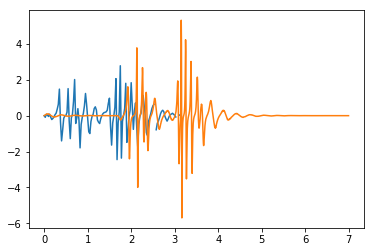

In [128]:
plt.plot(timesteps, emf_predicted_actual)
plt.plot(time_predicted, emf_predicted)

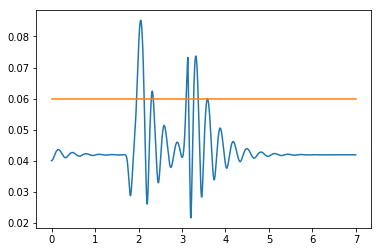

In [88]:
plt.plot(time_predicted, y_predicted)
plt.plot([0, 7], [0.06, 0.06])

In [89]:
y_x = np.abs(y_predicted - 0.06)

In [70]:
y_x.sort()

In [71]:
y_x

array([3.65305573e-06, 2.14985363e-05, 3.37123591e-05, ...,
       3.73173820e-02, 3.82273451e-02, 3.84299047e-02])